# About

This notebook builds an IR retrieve - rerank system. It uses the BiEncoder model finetuned using Notebook M003 to search for the top 20 passages for each query in Test set (retrieve system). Then, it uses the CrossEncoder model finetuned using Notebook M005 to rerank the top 20 passages for each query in Test set (rerank system). The retrieve - rerank system is evaluated by the top 10 ranked passages for each query in the Test set.

reference:
https://www.sbert.net/examples/applications/retrieve_rerank/README.html
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/cross-encoder/cross-encoder_reranking.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sentence_transformers import LoggingHandler, util, SentenceTransformer
from datetime import datetime
from sentence_transformers.cross_encoder import CrossEncoder
from torch.utils.data import DataLoader
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator, CEBinaryClassificationEvaluator
import gzip
import os
import tarfile
from sentence_transformers import InputExample, losses
from datetime import datetime
import time

In [ ]:
# #### Just some code to print debug information to stdout
# logging.basicConfig(
#     format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
# )
# #### /print debug information to stdout

# Define functions

In [2]:
def df_to_list(query_df, passage_df):
    """
    # this function create train, test data
    # it reads in query_df and passage_df, then for loop to create a list of list
    # each query, passage pair is a list of 4 elements: [query, passage, score, rel]
    # the ouput is [[query, passage, score, rel], [query, passage, score, rel], ...]
    """
    list_query_passage_score_rel = []
    for index, row in query_df.iterrows():
        list = []
        list.append(row['query'])
        list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
        list.append(row["score"])
        list.append(row["rel"])
        list_query_passage_score_rel.append(list)
    return list_query_passage_score_rel

# Read in Test set and Test set's rank produced by BiEncoder in M003

In [3]:
# Test set's query_id, and ranked top20 passage_id, it is produced by BiEncoder in M003
rank_test = pd.read_csv("./output/test_prediction_biencoder_refit_all-MiniLM-L6-v2_2024-04-22.csv")

# query
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")

# passage

passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")



In [4]:
print(rank_test.shape)
print(query_test.shape)
print(passage_test.shape)

(20000, 3)
(20000, 9)
(19854, 4)


# Merge query_test with ranked test and reorder the rows based on the rank predicted by BiEncoder

In [6]:
rank_test["rank_from_biencoder"] = rank_test.groupby("query_id").cumcount()+1

In [14]:
query_test_ = (query_test.merge(rank_test, how = "inner", on = ["query_id", "passage_id"])
                        .sort_values(["query_id", "rank_from_biencoder"]))

In [15]:
display(query_test_.head())

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,rank_from_biencoder
6044,5036,Meaning behind the name Ellen,Q0,msmarco_passage_38_636905305,5,11.6657,Anserini,1,meaning behind the name ellen,0.989431,1
6049,5036,Meaning behind the name Ellen,Q0,msmarco_passage_08_677691111,10,11.1507,Anserini,1,meaning behind the name ellen,0.989245,2
6043,5036,Meaning behind the name Ellen,Q0,msmarco_passage_04_387956244,4,11.8233,Anserini,1,meaning behind the name ellen,0.986520,3
6040,5036,Meaning behind the name Ellen,Q0,msmarco_passage_67_958670125,1,11.8884,Anserini,1,meaning behind the name ellen,0.979658,4
6057,5036,Meaning behind the name Ellen,Q0,msmarco_passage_04_387953029,98,8.9513,Anserini,0,meaning behind the name ellen,0.979237,5


In [16]:
display(query_test_.tail())

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,rank_from_biencoder
10369,1183224,foods to eat for malabsorption,Q0,msmarco_passage_48_449276269,10,11.935500,Anserini,1,foods to eat for malabsorption,0.951552,16
10360,1183224,foods to eat for malabsorption,Q0,msmarco_passage_64_307501210,1,12.564200,Anserini,1,foods to eat for malabsorption,0.950863,17
10371,1183224,foods to eat for malabsorption,Q0,msmarco_passage_01_493126868,92,10.199600,Anserini,0,foods to eat for malabsorption,0.949798,18
10373,1183224,foods to eat for malabsorption,Q0,msmarco_passage_09_689048460,94,10.197899,Anserini,0,foods to eat for malabsorption,0.949683,19
10376,1183224,foods to eat for malabsorption,Q0,msmarco_passage_61_527867091,97,10.197896,Anserini,0,foods to eat for malabsorption,0.949683,20


# Load in Cross Encoder model fit in M005

In [17]:
# #Load BiEncoder model produced in in M003
# model_save_path = "output/bi-encoder-finetuneall-MiniLM-L6-v2-2024-04-21_20-27-45"
# bi_encoder_model = SentenceTransformer(model_save_path)

#Load CrossEncoder model produced in in M005
model_save_path = "output/training_ms-marco_cross-encoder-cross-encoder-stsb-TinyBERT-L-4-2024-04-20_13-42-13"
cross_encoder_model = CrossEncoder(model_save_path)

# Prepare input for Test Set's Inference

In [18]:
def create_data_for_inference(query_df, passage_df):
    """
    # this function for loop each query, create list_query_passage (a list of list) for every query: [[query1, passage1], [query1, passage2] ....]
    # then pass this query's list_query_passage to model to make prediction, each query will return a score (list): [score1, score2, score3 ....]
    # the ouput dict_qid_all_prediction is a dictionary that append all query's list_score: {qid1: [score1, score2, score3 ....]}
    # the ouput dict_qid_pid_true is a dictionary that append all query's True ranked qassage {qid1: [pid1, pid2, ..., pid of topn]}
    """

    # create a list of list for all queries [[query1, passage1], [query1, passage2]..., [query2, passage1], [query2, passage2]..., ]
    # This would be used to fit into model to make prediction
    list_query_passage = []


    # create a list of list for all queries [[qid1, pid1], [qid1, pid2]..., [qid2, pid1], [qid2, pid2]..., ]
    # This would be used to collect and sort model prediction
    list_qid_all_pid = []

    # create a dict of dict for all queries {qid1: {pid1: rel, pid2: rel, ...}, qid2: {pid1: rel, pid2: rel, ...}, }
    # This would be used to evaluate model prediction
    dict_of_dict_qid_pid_rel = {}

    # iterate over all qid
    list_qid = query_df["query_id"].unique()
    for qid in list_qid:

        
        # get the rows that contains the qid, pid, score, rel for this qid
        query_df_subset = query_df[query_df['query_id'] == qid]
        
        # iterate over all pid
        for index, row in query_df_subset.iterrows():
            
            # create a list of 2 elements [query, passage]
            list = []
            list.append(row['query'])

            # get the only 1 row that contains the passage text in passage_df and whose pid matches the row's pid
            list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0]) # get passage value

            # append all lists of 2 elements of all queries into one list
            list_query_passage.append(list)

            # append the sublist. Each sublist is the [qid, pid] of the query
            list_qid_all_pid.append([row['query_id'], passage_df[passage_df['passage_id'] == row['passage_id']]['passage_id'].iloc[0]])

        
        
        # for this query, create a dictionary of Y true - each key is a pid, each value is the relavence (1 or 0) of the passage {pid1: 1, pid2, 0, ....}
        dict_pid_rel = pd.Series(query_df_subset['rel'].values, index = query_df_subset['passage_id']).to_dict()

        # append the dict of this query to the dict for all queries 
        dict_of_dict_qid_pid_rel[qid] = dict_pid_rel

    return list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel

In [19]:
list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel = create_data_for_inference(query_test_, passage_test)

In [20]:

# check
print(len(list_query_passage))
print(list_query_passage[0])
print(list_query_passage[1000])

print(len(list_qid_all_pid))
print(len(list_qid_all_pid[0]))
print(list_qid_all_pid[0])

print(len(dict_of_dict_qid_pid_rel))
print(len(dict_of_dict_qid_pid_rel[203324]))
print(dict_of_dict_qid_pid_rel[203324])

20000
['Meaning behind the name Ellen', 'What is the meaning of the name Ellen? The name Ellen is primarily a female name of Greek origin that means Light. Form of the name Helen.']
['calcium content in almonds', 'Minerals. Almonds are the clear winner in this category, containing large amounts of calcium, magnesium, potassium, phosphorus, iron and choline. The calcium content found in almonds is almost three times higher when compared to the calcium content of walnuts.']
20000
2
[5036, 'msmarco_passage_38_636905305']
1000
20
{'msmarco_passage_24_583711786': 1, 'msmarco_passage_65_238890762': 0, 'msmarco_passage_49_115778700': 1, 'msmarco_passage_58_723159152': 1, 'msmarco_passage_02_47181174': 1, 'msmarco_passage_02_47511835': 1, 'msmarco_passage_53_560231782': 0, 'msmarco_passage_59_733040871': 0, 'msmarco_passage_11_636220699': 1, 'msmarco_passage_28_623516004': 1, 'msmarco_passage_19_202396335': 1, 'msmarco_passage_02_835063630': 0, 'msmarco_passage_41_133447691': 1, 'msmarco_passa

In [21]:
# predict 
list_score = cross_encoder_model.predict(list_query_passage)

In [22]:
test_with_pred = pd.DataFrame(list_qid_all_pid, columns = ['query_id', 'passage_id'])
test_with_pred['predicted_score'] = list_score
test_with_pred.sort_values(by=['query_id', 'predicted_score'], ascending = False, inplace = True)
test_with_pred.to_csv("./output/test_prediction_rerank_2024-04-23.csv"
                                       , index = False)
print(test_with_pred.shape)

(20000, 3)


In [23]:
# check
display(test_with_pred[test_with_pred["query_id"] == 1183224])

,query_id,passage_id,predicted_score
19996,1183224,msmarco_passage_64_307501210,0.902275
19994,1183224,msmarco_passage_03_2856732,0.737706
19990,1183224,msmarco_passage_01_536296949,0.688284
19991,1183224,msmarco_passage_06_770443306,0.688284
19992,1183224,msmarco_passage_48_764103270,0.688284
19993,1183224,msmarco_passage_48_800555103,0.688284
19980,1183224,msmarco_passage_37_349325721,0.670941
19984,1183224,msmarco_passage_27_266644928,0.640532
19997,1183224,msmarco_passage_01_493126868,0.614931
19995,1183224,msmarco_passage_48_449276269,0.610131


# Plot distribution of predicted score

(array([216., 194., 202., 186., 176., 192., 197., 234., 245., 227., 275.,
        291., 285., 340., 333., 336., 361., 422., 446., 469., 481., 587.,
        602., 606., 628., 700., 659., 668., 801., 711., 791., 786., 836.,
        820., 747., 666., 687., 586., 599., 435., 337., 253., 156.,  88.,
         45.,  58.,  26.,  11.,   2.,   1.]),
 array([0.02170377, 0.0405684 , 0.05943304, 0.07829767, 0.09716231,
        0.11602694, 0.13489157, 0.15375622, 0.17262085, 0.19148548,
        0.21035011, 0.22921474, 0.24807937, 0.26694402, 0.28580865,
        0.30467328, 0.32353792, 0.34240255, 0.36126718, 0.38013181,
        0.39899644, 0.41786107, 0.43672574, 0.45559037, 0.474455  ,
        0.49331963, 0.51218426, 0.53104889, 0.54991353, 0.56877816,
        0.58764279, 0.60650742, 0.62537205, 0.64423668, 0.66310132,
        0.68196595, 0.70083058, 0.71969521, 0.73855984, 0.75742453,
        0.77628917, 0.7951538 , 0.81401843, 0.83288306, 0.85174769,
        0.87061232, 0.88947695, 0.90834159, 0.

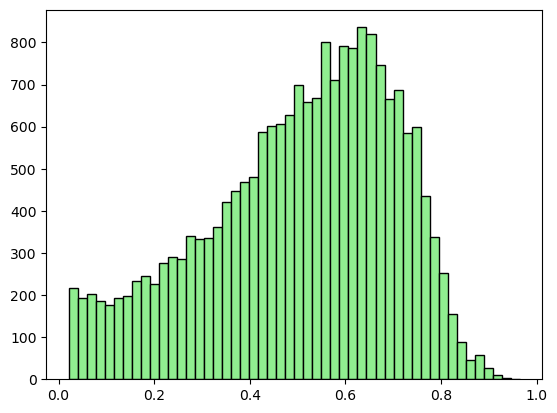

In [24]:
plt.hist(test_with_pred["predicted_score"], color='lightgreen', ec='black', bins=50)

# Evaluate using MRR@10

In [25]:
dict_qid_all_pid_prediction = {}

for qid, group in test_with_pred.groupby('query_id'):
    dict_qid_all_pid_prediction[qid] = group['passage_id'].values.tolist()

In [26]:

topn = 10
mrr = 0.0
qids = []
rrs = []

# iterate over all the qid (keys in the dictionary)
for qid in dict_qid_all_pid_prediction:

    rr = 0.0
    
    # iterate over all the element of topn pid [pid1, pid2, ... pid topn]
    for i, pid in enumerate(dict_qid_all_pid_prediction[qid][: topn + 1]):

        # check if the pid has relenvace > 0
        if qid in dict_of_dict_qid_pid_rel and pid in dict_of_dict_qid_pid_rel[qid] and dict_of_dict_qid_pid_rel[qid][pid] > 0:
        
            rr = 1 / (i+1)
        
            break
    qids.append(qid)
    rrs.append(rr)
    mrr += rr
mrr /= len(dict_qid_all_pid_prediction)
print("MRR@10: ", mrr)

MRR@10:  0.946619047619048


# Evaluate using MAP@10

In [27]:
print(query_test.shape)
print(test_with_pred.shape)

result = query_test.merge(test_with_pred, how = "inner", on = ["query_id", "passage_id"])
print(result.shape)
display(result.head())

(20000, 9)
(20000, 3)
(20000, 10)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.572222
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.512837
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.457086
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.592055
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.542745


In [28]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [29]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [30]:
result.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,avg_precision
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.572222,0.873413
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.512837,0.873413
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.457086,0.873413
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.592055,0.873413
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.542745,0.873413


In [31]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.8848143230347694


In [32]:
result.to_csv("./output/test_prediction_rerank_2024-04-23.csv"
                                       , index = False)
